In [1]:
from google.colab import drive
drive.mount('/content/drive')



#Importing data from kaggle settings
! pip install kaggle 
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tmdb/tmdb-movie-metadata
! unzip tmdb-movie-metadata.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
tmdb-movie-metadata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tmdb-movie-metadata.zip
replace tmdb_5000_credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tmdb_5000_movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Content Based Recommender System

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
movies=pd.read_csv('/content/tmdb_5000_movies.csv')
credits=pd.read_csv('/content/tmdb_5000_credits.csv')
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
df=movies.merge(credits, on='title')

In [6]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Preprocessing

In [7]:
df = df[['movie_id','title','overview','genres','keywords','cast','crew','vote_count','vote_average','popularity']]

In [8]:
df.isnull().sum()

movie_id        0
title           0
overview        3
genres          0
keywords        0
cast            0
crew            0
vote_count      0
vote_average    0
popularity      0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [12]:
def convert_from_json_to_ls(dic):
    ls=[]
    for elem in dic:
        ls.append(elem['name'])
    return ls

def convert_from_json_3_actors(dic):
    ls=[]
    counter=0
    for elem in dic:
        if counter!=3:
            ls.append(elem['name'])
            counter+=1
        else:
            break
    return ls

def convert_from_json_director(dic):
    ls=[]
    for elem in dic:
        if elem['job']=="Director":
            ls.append(elem['name'])
            break
    return ls

def remove_white_space(lis):
    ls = []
    for sp in lis:
        ls.append(sp.replace(" ",""))
    return ls

In [13]:
import json
df['genres'] = df['genres'].apply(json.loads)
df['genres']=df['genres'].apply(convert_from_json_to_ls)

df['keywords'] = df['keywords'].apply(json.loads)
df['keywords']=df['keywords'].apply(convert_from_json_to_ls)

df['crew'] = df['crew'].apply(json.loads)
df['crew']=df['crew'].apply(convert_from_json_director)

df['cast'] = df['cast'].apply(json.loads)
df['cast']=df['cast'].apply(convert_from_json_3_actors)

df['overview']=df['overview'].apply(lambda x:x.split())

# connecting all words together in 1 sentence
df['cast'] = df['cast'].apply(remove_white_space)
df['crew'] = df['crew'].apply(remove_white_space)
df['genres'] = df['genres'].apply(remove_white_space)
df['keywords'] = df['keywords'].apply(remove_white_space)

#combining all the columns in one
df['content']=df['cast']+df['crew']+df['genres']+df['keywords']

In [14]:
df.tail()

,movie_id,title,overview,genres,keywords,cast,crew,vote_count,vote_average,popularity,content
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui...","[Action, Crime, Thriller]","[unitedstates–mexicobarrier, legs, arms, paper...","[CarlosGallardo, JaimedeHoyos, PeterMarquardt]",[RobertRodriguez],238,6.6,14.269792,"[CarlosGallardo, JaimedeHoyos, PeterMarquardt,..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended...","[Comedy, Romance]",[],"[EdwardBurns, KerryBishé, MarshaDietlein]",[EdwardBurns],5,5.9,0.642552,"[EdwardBurns, KerryBishé, MarshaDietlein, Edwa..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,...","[Comedy, Drama, Romance, TVMovie]","[date, loveatfirstsight, narration, investigat...","[EricMabius, KristinBooth, CrystalLowe]",[ScottSmith],6,7.0,1.444476,"[EricMabius, KristinBooth, CrystalLowe, ScottS..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is...",[],[],"[DanielHenney, ElizaCoupe, BillPaxton]",[DanielHsia],7,5.7,0.857008,"[DanielHenney, ElizaCoupe, BillPaxton, DanielH..."
4808,25975,My Date with Drew,"[Ever, since, the, second, grade, when, he, fi...",[Documentary],"[obsession, camcorder, crush, dreamgirl]","[DrewBarrymore, BrianHerzlinger, CoreyFeldman]",[BrianHerzlinger],16,6.3,1.929883,"[DrewBarrymore, BrianHerzlinger, CoreyFeldman,..."


## EDA

Text(0.5, 1.0, 'Popular Movies')

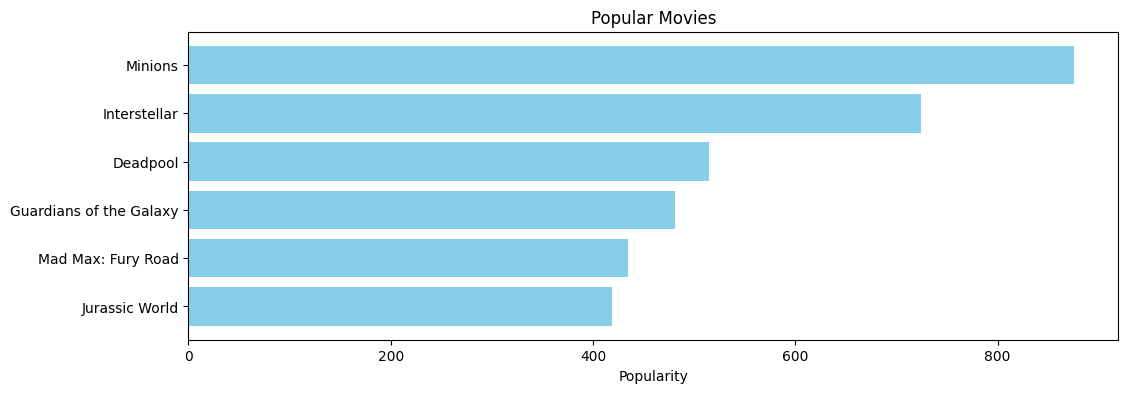

In [15]:
pop= df.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

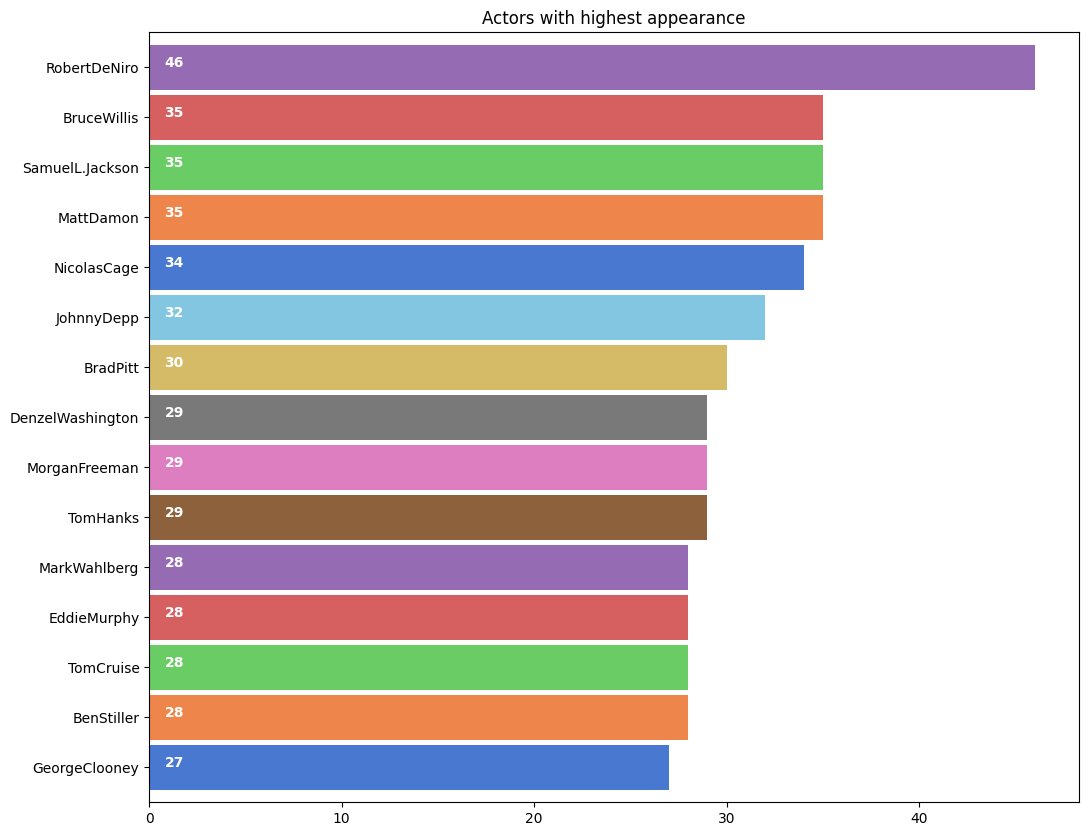

In [16]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

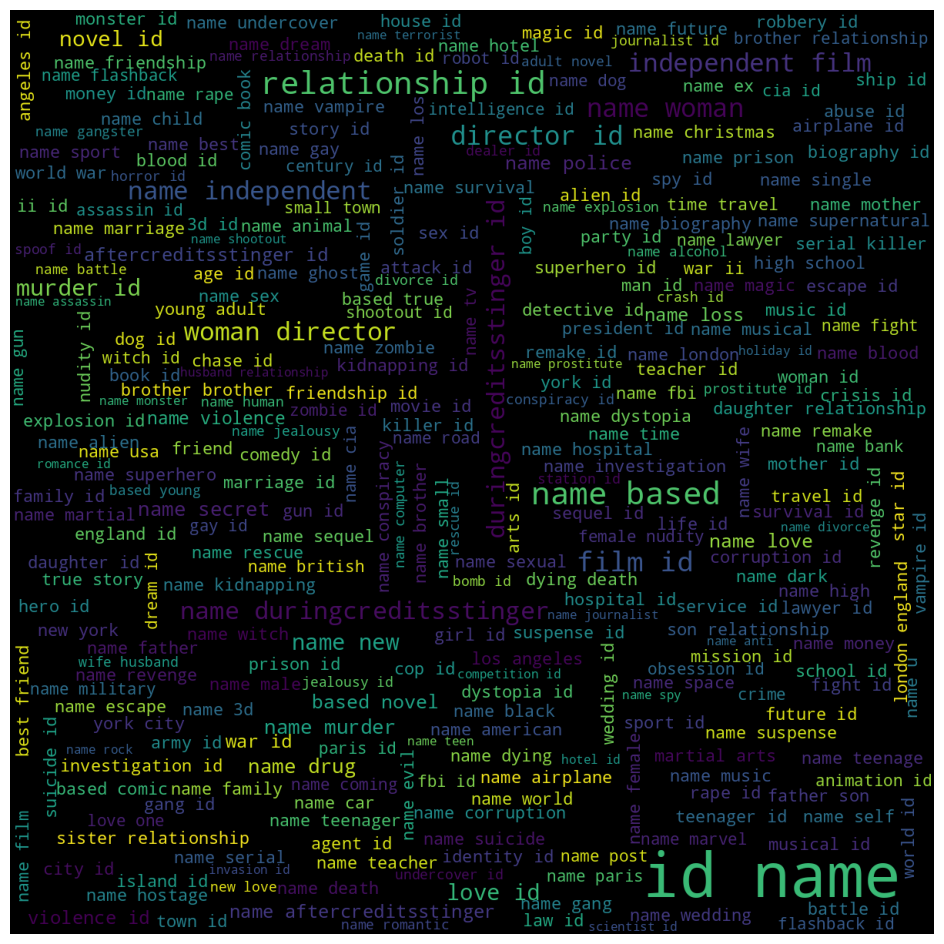

In [17]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=300, stopwords=stop_words, max_font_size= 80,width=1200,height=1200)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## Prediction

In [18]:
df_final=df[['movie_id','title','content']]
df_final['title']=df_final['title'].apply(lambda x:x.lower())
df_final['content']=df_final['content'].apply(lambda x:' '.join(x))
df_final['content']=df_final['content'].apply(lambda x: x.lower())

<ipython-input-18-b6d8c2fd1f7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['title']=df_final['title'].apply(lambda x:x.lower())
<ipython-input-18-b6d8c2fd1f7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['content']=df_final['content'].apply(lambda x:' '.join(x))
<ipython-input-18-b6d8c2fd1f7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [19]:
cv = CountVectorizer(max_features=5000, stop_words='english')

In [20]:
vectors=cv.fit_transform(df_final['content']).toarray()

In [21]:
# printing the first movie's BOW vector
vectors[0]

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
cv.get_feature_names_out()

array(['16thcentury', '17thcentury', '18thcentury', ..., 'zoo',
       'zooeydeschanel', 'zoëkravitz'], dtype=object)

In [23]:
ps= PorterStemmer()
def stem(text):
    corpus=[]
    for word in text.split():
        corpus.append(ps.stem(word))

    return ' '.join(corpus)

In [24]:
df_final ['content']=df_final['content'].apply(stem)

<ipython-input-24-b8edc1588ed9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final ['content']=df_final['content'].apply(stem)


In [25]:
# the similarity between each movie
similarity = cosine_similarity(vectors)

In [26]:
def recommend(movie):
    recommended_movies = []
    movie_index = df_final[df_final['title'] == movie.lower()].index[0]
    distance = similarity[movie_index]
    # it has a tuple of the index and similarity score of the top 5 similar movies
    movies_list = sorted(list(enumerate(similarity[0])), reverse=True, key=lambda x: x[1])[1:6]
    for movie in movies_list:
        recommended_movies.append(df_final.iloc[movie[0]].title)
    return recommended_movies

In [27]:
print(recommend('Avatar'))

['star trek into darkness', 'megaforce', 'jupiter ascending', 'the lovers', 'aliens']


## Exporting & Pickling

In [28]:
#import pickle
#pickle.dump(df,open('movies.pkl','wb'))
#pickle.dump(similarity,open('similarity.pkl','wb'))

# Movie Recommendation Based on Weighted Average Scores(TMDB Dataset)

## Imports

In [29]:
from sklearn.preprocessing import MinMaxScaler

W = (Rv+Cm)/(v+m)


> W = Weighted Rating

>R = average for the movie(0 to 10) = Rating

>v = number of votes for the movie

>m = minimum votes required to be listed in Top 250

>C = Mean vote across whole Report

## Preprocessing

In [30]:
v = movies['vote_count']
R = movies['vote_average']
C = movies['vote_average'].mean()
m = movies['vote_count'].quantile(0.70)    # Movies > 70th percentile votes

df['weighted_avg'] = ((R*v)+(C*m))/(v+m)

sorted_ranking_df = df.sort_values('weighted_avg', ascending=False)
sorted_ranking_df

,movie_id,title,overview,genres,keywords,cast,crew,vote_count,vote_average,popularity,content,weighted_avg
1881,4518,Elizabeth,"[The, story, of, the, ascension, to, the, thro...","[Drama, History]","[duke, historicalfigure, treason, catholic, pr...","[CateBlanchett, GeoffreyRush, ChristopherEccle...",[ShekharKapur],334,7.1,14.179538,"[CateBlanchett, GeoffreyRush, ChristopherEccle...",8.340775
3337,25941,Harry Brown,"[An, elderly, ex-serviceman, and, widower, loo...","[Thriller, Crime, Drama, Action]","[self-defense, widower]","[MichaelCaine, EmilyMortimer, IainGlen]",[DanielBarber],348,6.7,16.829837,"[MichaelCaine, EmilyMortimer, IainGlen, Daniel...",8.192887
662,550,Fight Club,"[A, ticking-time-bomb, insomniac, and, a, slip...",[Drama],"[supportgroup, dualidentity, nihilism, rageand...","[EdwardNorton, BradPitt, MeatLoaf]",[DavidFincher],9413,8.3,146.757391,"[EdwardNorton, BradPitt, MeatLoaf, DavidFinche...",8.171648
3232,1116,The Wind That Shakes the Barley,"[Set, during, the, 1920’s, Irish, revolution, ...","[Drama, History, War]","[londonengland, brotherbrotherrelationship, en...","[CillianMurphy, PádraicDelaney, LiamCunningham]",[KenLoach],154,7.1,6.787967,"[CillianMurphy, PádraicDelaney, LiamCunningham...",8.157615
65,155,The Dark Knight,"[Batman, raises, the, stakes, in, his, war, on...","[Drama, Action, Crime, Thriller]","[dccomics, crimefighter, secretidentity, scare...","[ChristianBale, HeathLedger, AaronEckhart]",[ChristopherNolan],12002,8.2,187.322927,"[ChristianBale, HeathLedger, AaronEckhart, Chr...",8.102674
...,...,...,...,...,...,...,...,...,...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui...","[Action, Crime, Thriller]","[unitedstates–mexicobarrier, legs, arms, paper...","[CarlosGallardo, JaimedeHoyos, PeterMarquardt]",[RobertRodriguez],238,6.6,14.269792,"[CarlosGallardo, JaimedeHoyos, PeterMarquardt,...",NaN
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended...","[Comedy, Romance]",[],"[EdwardBurns, KerryBishé, MarshaDietlein]",[EdwardBurns],5,5.9,0.642552,"[EdwardBurns, KerryBishé, MarshaDietlein, Edwa...",NaN
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,...","[Comedy, Drama, Romance, TVMovie]","[date, loveatfirstsight, narration, investigat...","[EricMabius, KristinBooth, CrystalLowe]",[ScottSmith],6,7.0,1.444476,"[EricMabius, KristinBooth, CrystalLowe, ScottS...",NaN
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is...",[],[],"[DanielHenney, ElizaCoupe, BillPaxton]",[DanielHsia],7,5.7,0.857008,"[DanielHenney, ElizaCoupe, BillPaxton, DanielH...",NaN


In [31]:
sorted_ranking_df[['title', 'vote_count', 'vote_average', 'weighted_avg', 'popularity']].head()

,title,vote_count,vote_average,weighted_avg,popularity
1881,Elizabeth,334,7.1,8.340775,14.179538
3337,Harry Brown,348,6.7,8.192887,16.829837
662,Fight Club,9413,8.3,8.171648,146.757391
3232,The Wind That Shakes the Barley,154,7.1,8.157615,6.787967
65,The Dark Knight,12002,8.2,8.102674,187.322927


## EDA

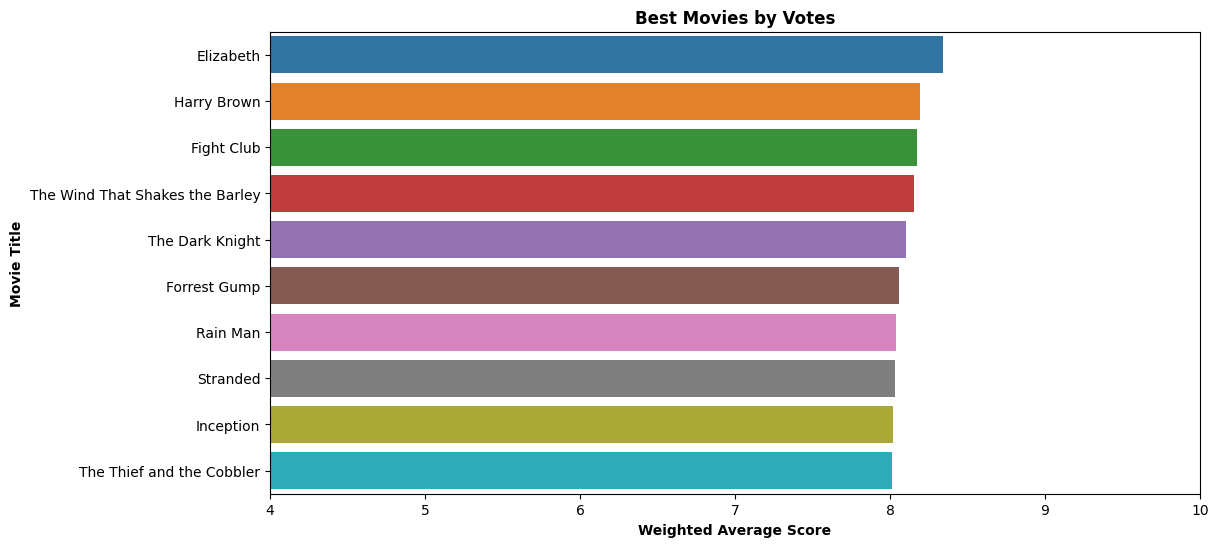

In [32]:
weight_avg = sorted_ranking_df.sort_values('weighted_avg', ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = weight_avg['weighted_avg'].head(10), y=weight_avg['title'].head(10), data=weight_avg)
plt.xlim(4, 10)
plt.title("Best Movies by Votes", weight="bold")
plt.xlabel("Weighted Average Score", weight="bold")
plt.ylabel("Movie Title", weight="bold")
plt.show()

## Prediciton

In [33]:
scaling = MinMaxScaler()
movie_scaled = scaling.fit_transform(df[['weighted_avg', 'popularity']])
movie_normalized = pd.DataFrame(movie_scaled, columns=['weighted_avg', 'popularity'])
movie_normalized.head()

,weighted_avg,popularity
0,0.674339,0.171815
1,0.581403,0.158846
2,0.436273,0.122635
3,0.773054,0.128272
4,0.387739,0.050169


In [34]:
df[['normalized_weighted_avg', 'normalized_popularity']] = movie_normalized
df.head(5)

,movie_id,title,overview,genres,keywords,cast,crew,vote_count,vote_average,popularity,content,weighted_avg,normalized_weighted_avg,normalized_popularity
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],11800,7.2,150.437577,"[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",7.148013,0.674339,0.171815
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],4500,6.9,139.082615,"[JohnnyDepp, OrlandoBloom, KeiraKnightley, Gor...",6.807627,0.581403,0.158846
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],4466,6.3,107.376788,"[DanielCraig, ChristophWaltz, LéaSeydoux, SamM...",6.276075,0.436273,0.122635
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],9106,7.6,112.312950,"[ChristianBale, MichaelCaine, GaryOldman, Chri...",7.509565,0.773054,0.128272
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2124,6.1,43.926995,"[TaylorKitsch, LynnCollins, SamanthaMorton, An...",6.098319,0.387739,0.050169


In [35]:
df['score'] = df['normalized_weighted_avg'] * 0.5 + df['normalized_popularity'] * 0.5
df = df.sort_values(['score'], ascending=False)
df[['title','normalized_weighted_avg', 'normalized_popularity', 'score']].head(5)

,title,normalized_weighted_avg,normalized_popularity,score
95,Interstellar,0.906439,0.827162,0.866801
546,Minions,0.460630,1.000000,0.730315
94,Guardians of the Galaxy,0.851874,0.549462,0.700668
788,Deadpool,0.725217,0.587690,0.656453
127,Mad Max: Fury Road,0.670973,0.495989,0.583481


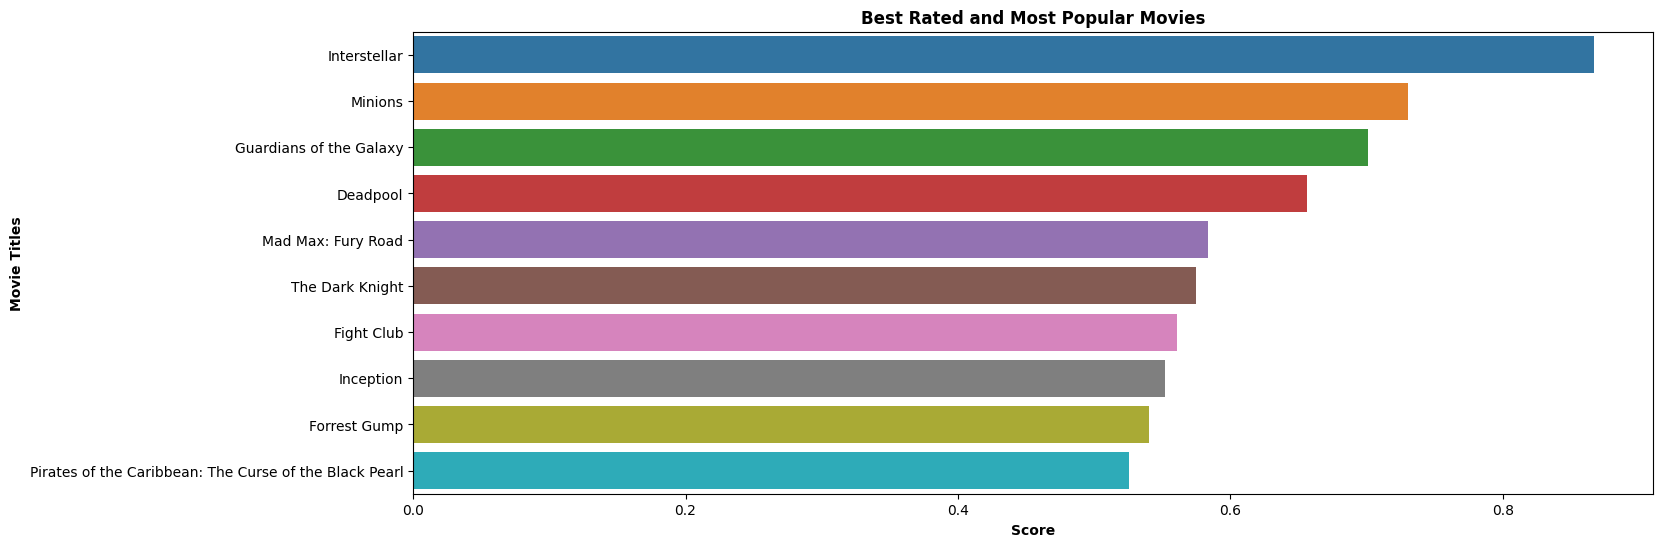

In [36]:
df = df.sort_values('score', ascending=False)

plt.figure(figsize=(16, 6))
ax = sns.barplot(x = df['score'].head(10), y=df['title'].head(10), data=df)
plt.title("Best Rated and Most Popular Movies", weight="bold")
plt.xlabel("Score", weight="bold")
plt.ylabel("Movie Titles", weight="bold")
plt.show()

# Special thanks to:

[EDA](https://www.kaggle.com/code/heeraldedhia/movie-ratings-and-recommendation-using-knn)

[EDA](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system)

[Colaborative sys](https://www.kaggle.com/code/codebreaker619/movie-recommender-system-collaborative#Movie-Recommendation-Based-on-Weighted-Average-Scores(TMDB-Dataset))

